In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from pyteomics import mass
from pyteomics import electrochem

import joblib

from utils.parseData import mz_to_mass
from utils.parseData import count_basic_residues
from utils.parseData import gererate_dic
from utils.parseData import PROTON_MASS
from utils.parseData import adjacent_values
from utils.parseData import set_axis_style
from utils.parseData import PH
from utils.parseData import data_path
from utils.parseData import find_peptide

# gererate_dic(data_path)

dic = joblib.load('data/dic.pkl')

___
# Generate Data Set

In [2]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    mass_2 = []
    residues_2 = []
    charge_2 = []
    mass_2_excel = []
    labels_2 = []
    residues_2_2 =[[],[],[],[],[]] 

    mass_3 = []
    residues_3 = []
    charge_3 = []
    mass_3_excel = []
    labels_3 = []
    residues_3_2 =[[],[],[],[],[]] 


    for i in dic.keys():
        for j in dic[i].keys():
            if j == 2 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues: 
                mass_2.append(dic[i][j]['Masse'])
                mass_2_excel.append(dic[i][j]['Mass_excel'])
                residues_2.append(count_basic_residues(dic[i][j]['sequence']))
                residues_2_2[count_basic_residues(dic[i][j]['sequence'])-1].append(dic[i][j]['%'])
                charge_2.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_2.append(dic[i][j]['%'])
            if j == 3 and dic[i][j]['%'] < 1 and electrochem.charge(dic[i][j]['sequence'], pH=PH) > min_charge and electrochem.charge(dic[i][j]['sequence'], pH=PH) < max_charge and dic[i][j]['Masse'] > min_mass and dic[i][j]['Masse'] < max_mass and count_basic_residues(dic[i][j]['sequence']) > min_residues and count_basic_residues(dic[i][j]['sequence']) < max_residues:
                mass_3.append(dic[i][j]['Masse'])
                mass_3_excel.append(dic[i][j]['Mass_excel'])
                residues_3.append(count_basic_residues(dic[i][j]['sequence']))
                residues_3_2[count_basic_residues(dic[i][j]['sequence'])-1].append(dic[i][j]['%'])
                charge_3.append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                labels_3.append(dic[i][j]['%'])
    
    return mass_2, residues_2, charge_2, mass_2_excel, residues_2_2, labels_2, mass_3, residues_3, charge_3, mass_3_excel, residues_3_2, labels_3

mass_2, residues_2, charge_2, mass_2_excel, residues_2_2, labels_2, mass_3, residues_3, charge_3, mass_3_excel, residues_2_3, labels_3 = generate_data(dic, min_charge=2)

In [3]:
def shuffle(l1, l2):
    temp = list(zip(l1, l2))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = np.array(res1), np.array(res2)
    return res1, res2

x_train = np.array([ [m, r, c] for m, r, c in zip(mass_2_excel, residues_2, charge_2) ])
y_train = np.array(labels_2)
print(x_train.shape, y_train.shape)
x_test = []
y_test = []

for _ in range(10):
    x_train, y_train = shuffle(x_train, y_train)

for i in range(round(x_train.shape[0]*0.25)):
    x_test.append(x_train[i])
    x_train = np.delete(x_train, i, 0)
    y_test.append(y_train[i])
    y_train = np.delete(y_train, i)

x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = (y_test*100).round().astype(int)
y_train = (y_train*100).round().astype(int)

(1886, 3) (1886,)


In [4]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (masse,residues,charge):', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (masse,residues,charge) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 1414 exemples
	• test : 472 exemples

Taille des données d'apprentissage
	• X_train (masse,residues,charge): (1414, 3)
	• y_train (labels) : (1414,)

Taille des données de test
	• X_test (masse,residues,charge) : (472, 3)
	• y_test (labels) : (472,)


## Ranking Data Set

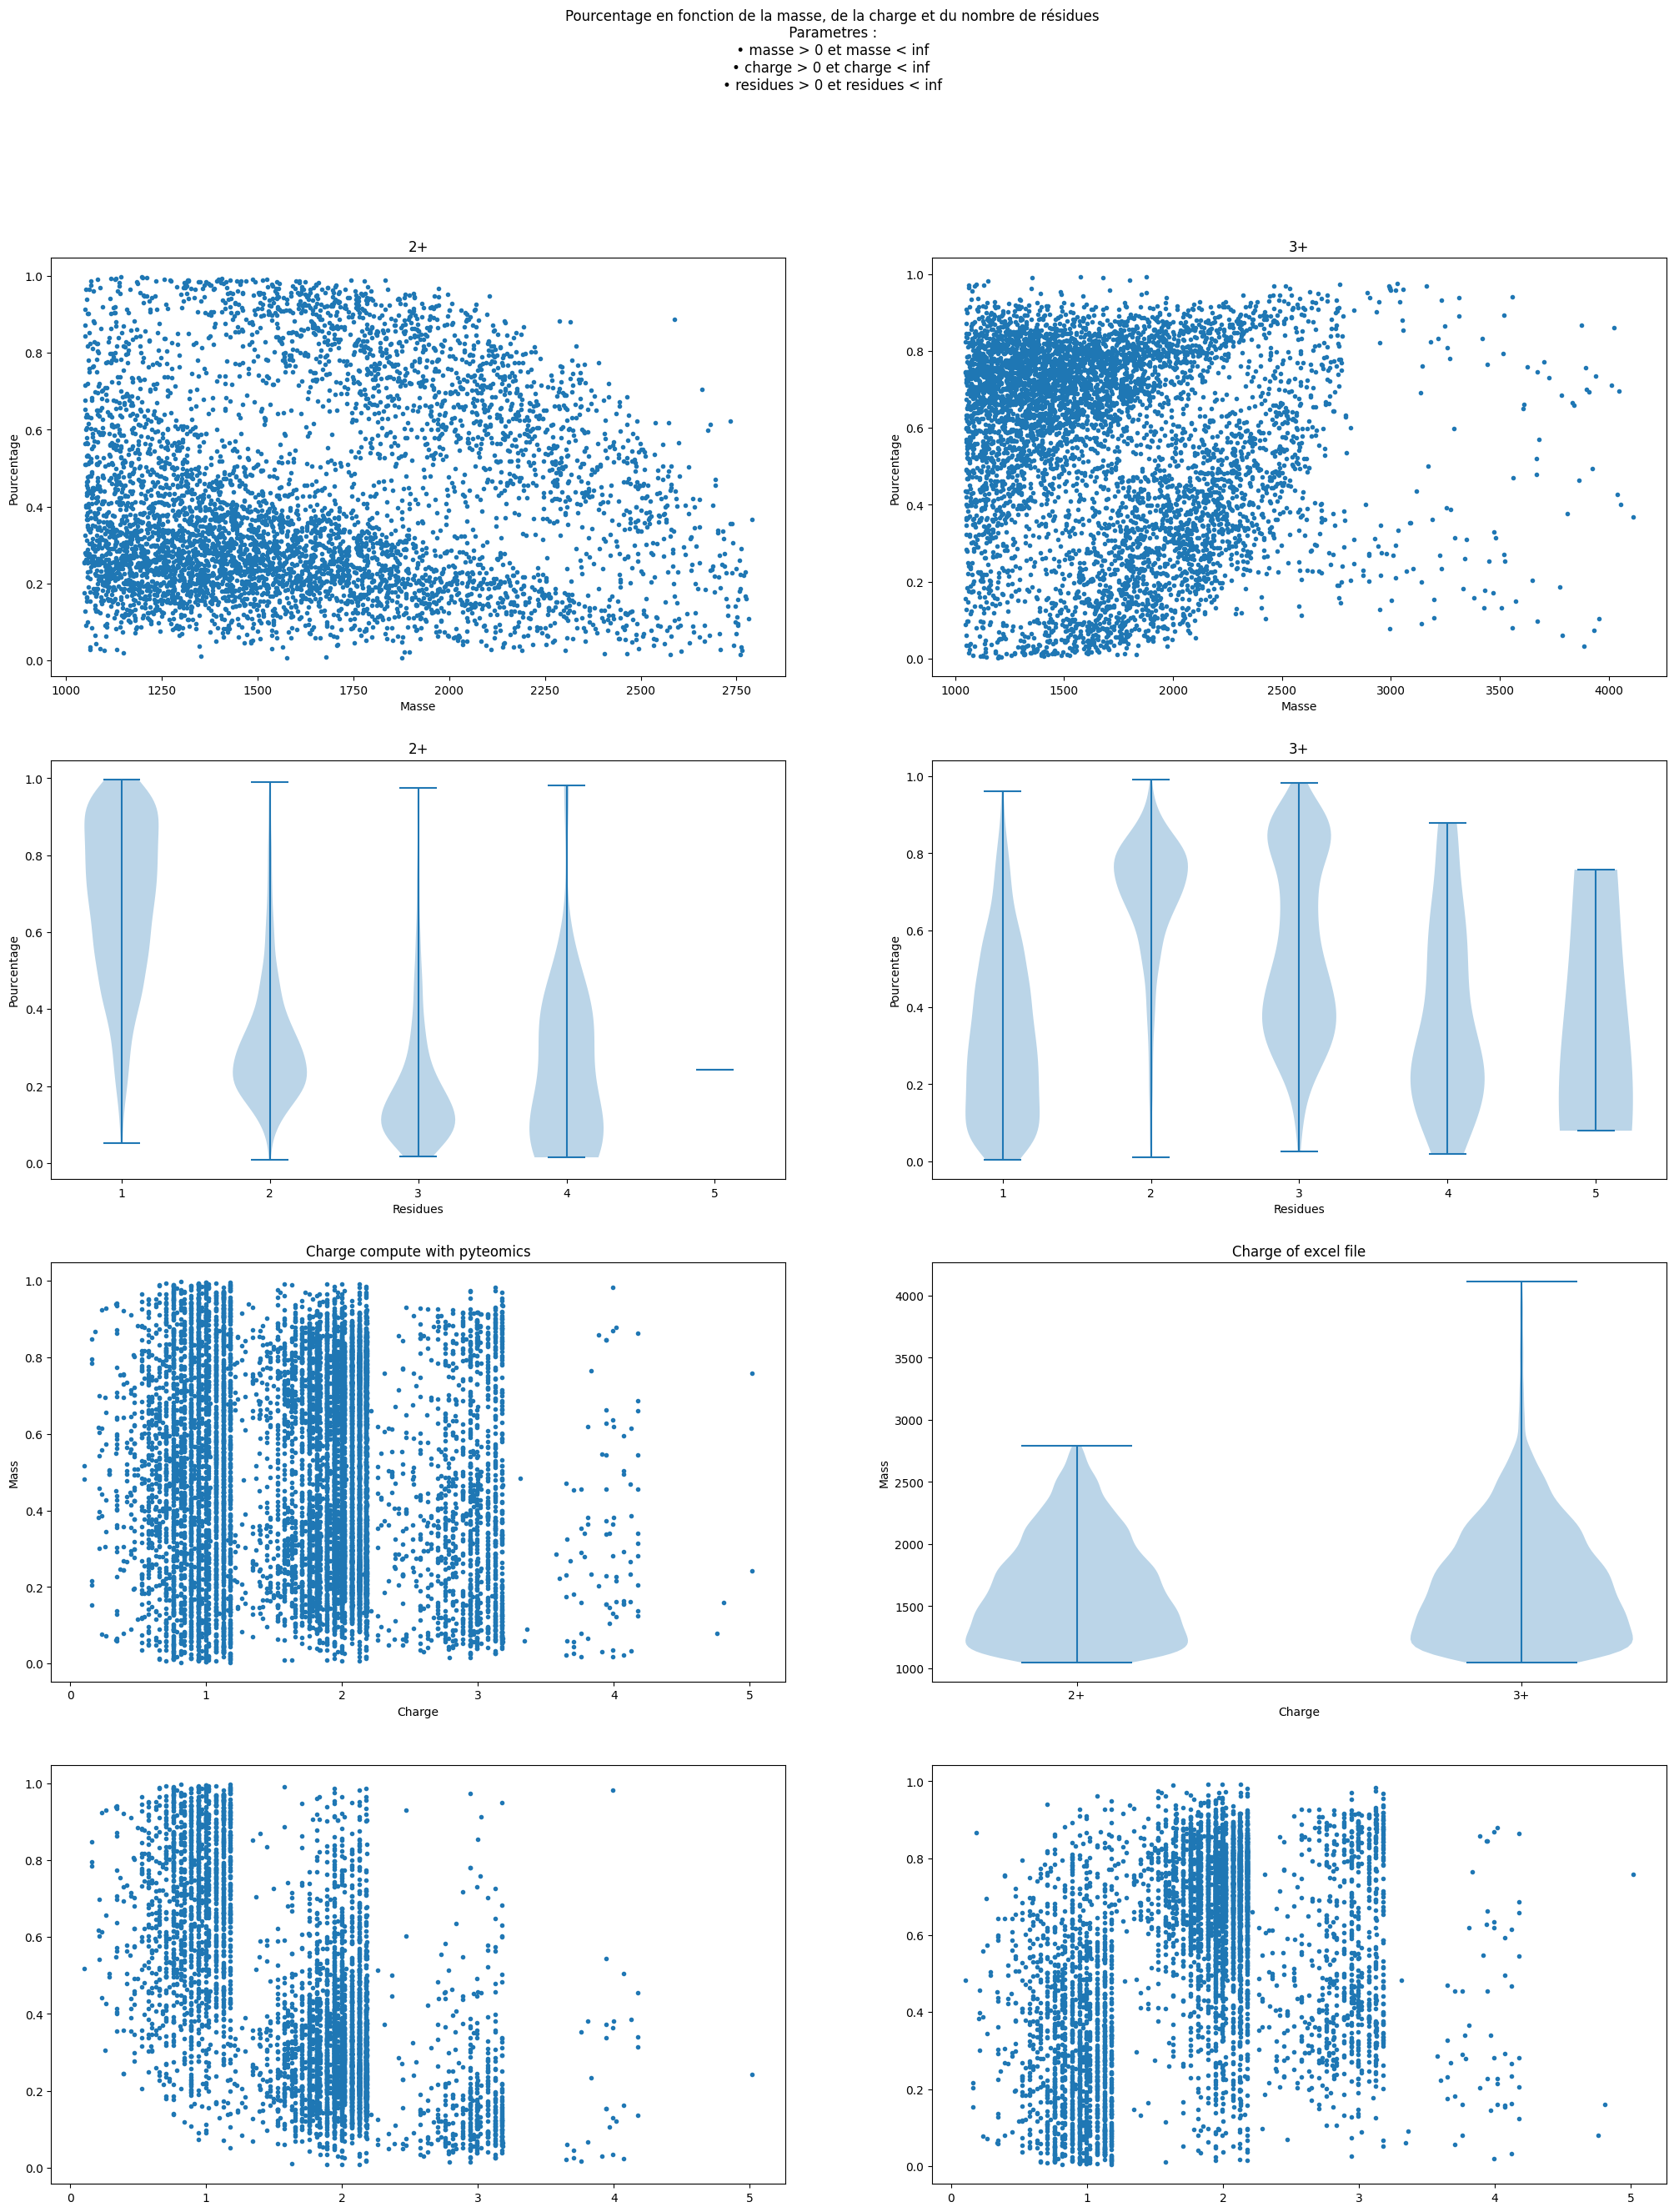

In [5]:
from sklearn.linear_model import LinearRegression
def ranking_dataset(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    a = 0.5-1750 / 0.7 - 1500
    f = lambda x: x*a + 0.5

    mass_2, residues_2, charge_2, mass_2_excel, residues_2_2, persents_2, mass_3, residues_3, charge_3, mass_3_excel, residues_3_2, persents_3 = generate_data(dic, min_mass, max_mass, min_charge, max_charge, min_residues, max_residues)
    mass_2_excel = np.array(mass_2_excel)
    mass_3_excel = np.array(mass_3_excel)
    persents_2 = np.array(persents_2)
    fig, ax = plt.subplots(4, 2, figsize=(25,30))
    # ax[0][0].plot(f(mass_2_excel), persents_2, '.')
    ax[0][0].plot(mass_2_excel, persents_2, '.')
    ax[0][0].set_xlabel("Masse")
    ax[0][0].set_ylabel("Pourcentage")
    ax[0][0].set_title('2+')
    ax[0][1].plot(mass_3_excel, persents_3, '.')
    ax[0][1].set_xlabel("Masse")
    ax[0][1].set_ylabel("Pourcentage")
    ax[0][1].set_title('3+')
    ax[1][0].violinplot(residues_2_2)
    ax[1][0].set_xlabel("Residues")
    ax[1][0].set_ylabel("Pourcentage")
    ax[1][0].set_title('2+')
    ax[1][1].violinplot(residues_3_2)
    ax[1][1].set_xlabel("Residues")
    ax[1][1].set_ylabel("Pourcentage")
    ax[1][1].set_title('3+')
    ax[2][0].plot(np.concatenate((charge_2,charge_3)), np.concatenate((persents_2,persents_3)), '.')
    ax[2][0].set_xlabel("Charge")
    ax[2][0].set_ylabel("Mass")
    ax[2][0].set_title('Charge compute with pyteomics')
    ax[2][1].violinplot( [mass_2_excel,mass_3_excel])
    ax[2][1].set_xticks([1,2],['2+','3+'])
    ax[2][1].set_xlabel("Charge")
    ax[2][1].set_ylabel("Mass")
    ax[2][1].set_title('Charge of excel file')
    ax[3][0].plot(charge_2, persents_2, '.')
    ax[3][1].plot(charge_3, persents_3, '.')

    fig.suptitle(f'Pourcentage en fonction de la masse, de la charge et du nombre de résidues\n Parametres : \n • masse > {min_mass} et masse < {max_mass if max_charge > np.inf else "inf" } \n• charge > {min_charge} et charge < {max_charge if max_charge > np.inf else "inf"} \n• residues > {min_residues} et residues < {max_residues if max_residues > np.inf else "inf"}')
    plt.show()

ranking_dataset(dic)

___


In [6]:
import matplotlib.patches as mpatches

In [7]:
def generate_data(dic, min_mass=0, max_mass=np.inf, min_charge=0, max_charge=np.inf, min_residues=0, max_residues=np.inf):
    residues = [[],[],[],[]]
    charge = [[],[],[],[]]
    mass = [[],[],[],[]]
    persents = [[],[],[],[]]
    labels = [[],[],[],[]]

    residues_2 = [[],[],[],[]]
    charge_2 = [[],[],[],[]]
    mass_2 = [[],[],[],[]]
    persents_2 = [[],[],[],[]]
    labels_2 = [[],[],[],[]]

    residues_3 = [[],[],[],[]]
    charge_3 = [[],[],[],[]]
    mass_3 = [[],[],[],[]]
    persents_3 = [[],[],[],[]]
    labels_3 = [[],[],[],[]]


    for i in dic.keys():
        for j in dic[i].keys():
            if j != 'total':
                if dic[i][j]['%'] < 1.0:
                    mass[j-2].append(dic[i][j]['Mass_excel'])
                    residues[j-2].append(count_basic_residues(dic[i][j]['sequence']))
                    charge[j-2].append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    persents[j-2].append(dic[i][j]['%'])
                    labels.append(j)
                if dic[i][j]['%'] >= 1.0:
                    mass_2[j-2].append(dic[i][j]['Mass_excel'])
                    residues_2[j-2].append(count_basic_residues(dic[i][j]['sequence']))
                    charge_2[j-2].append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                    persents_2[j-2].append(dic[i][j]['%'])
                    labels_2.append(j)
                
                mass_3[j-2].append(dic[i][j]['Mass_excel'])
                residues_3[j-2].append(count_basic_residues(dic[i][j]['sequence']))
                charge_3[j-2].append(electrochem.charge(dic[i][j]['sequence'], pH=PH))
                persents_3[j-2].append(dic[i][j]['%'])
                labels_3.append(j)

    return residues, charge, mass, persents, labels, residues_2, charge_2, mass_2, persents_2, residues_3, charge_3, mass_3, persents_3, labels_2, labels_3

residues, charge, mass, persents, labels, residues_2, charge_2, mass_2, persents_2, residues_3, charge_3, mass_3, persents_3, labels_2, labels_3 = generate_data(dic)

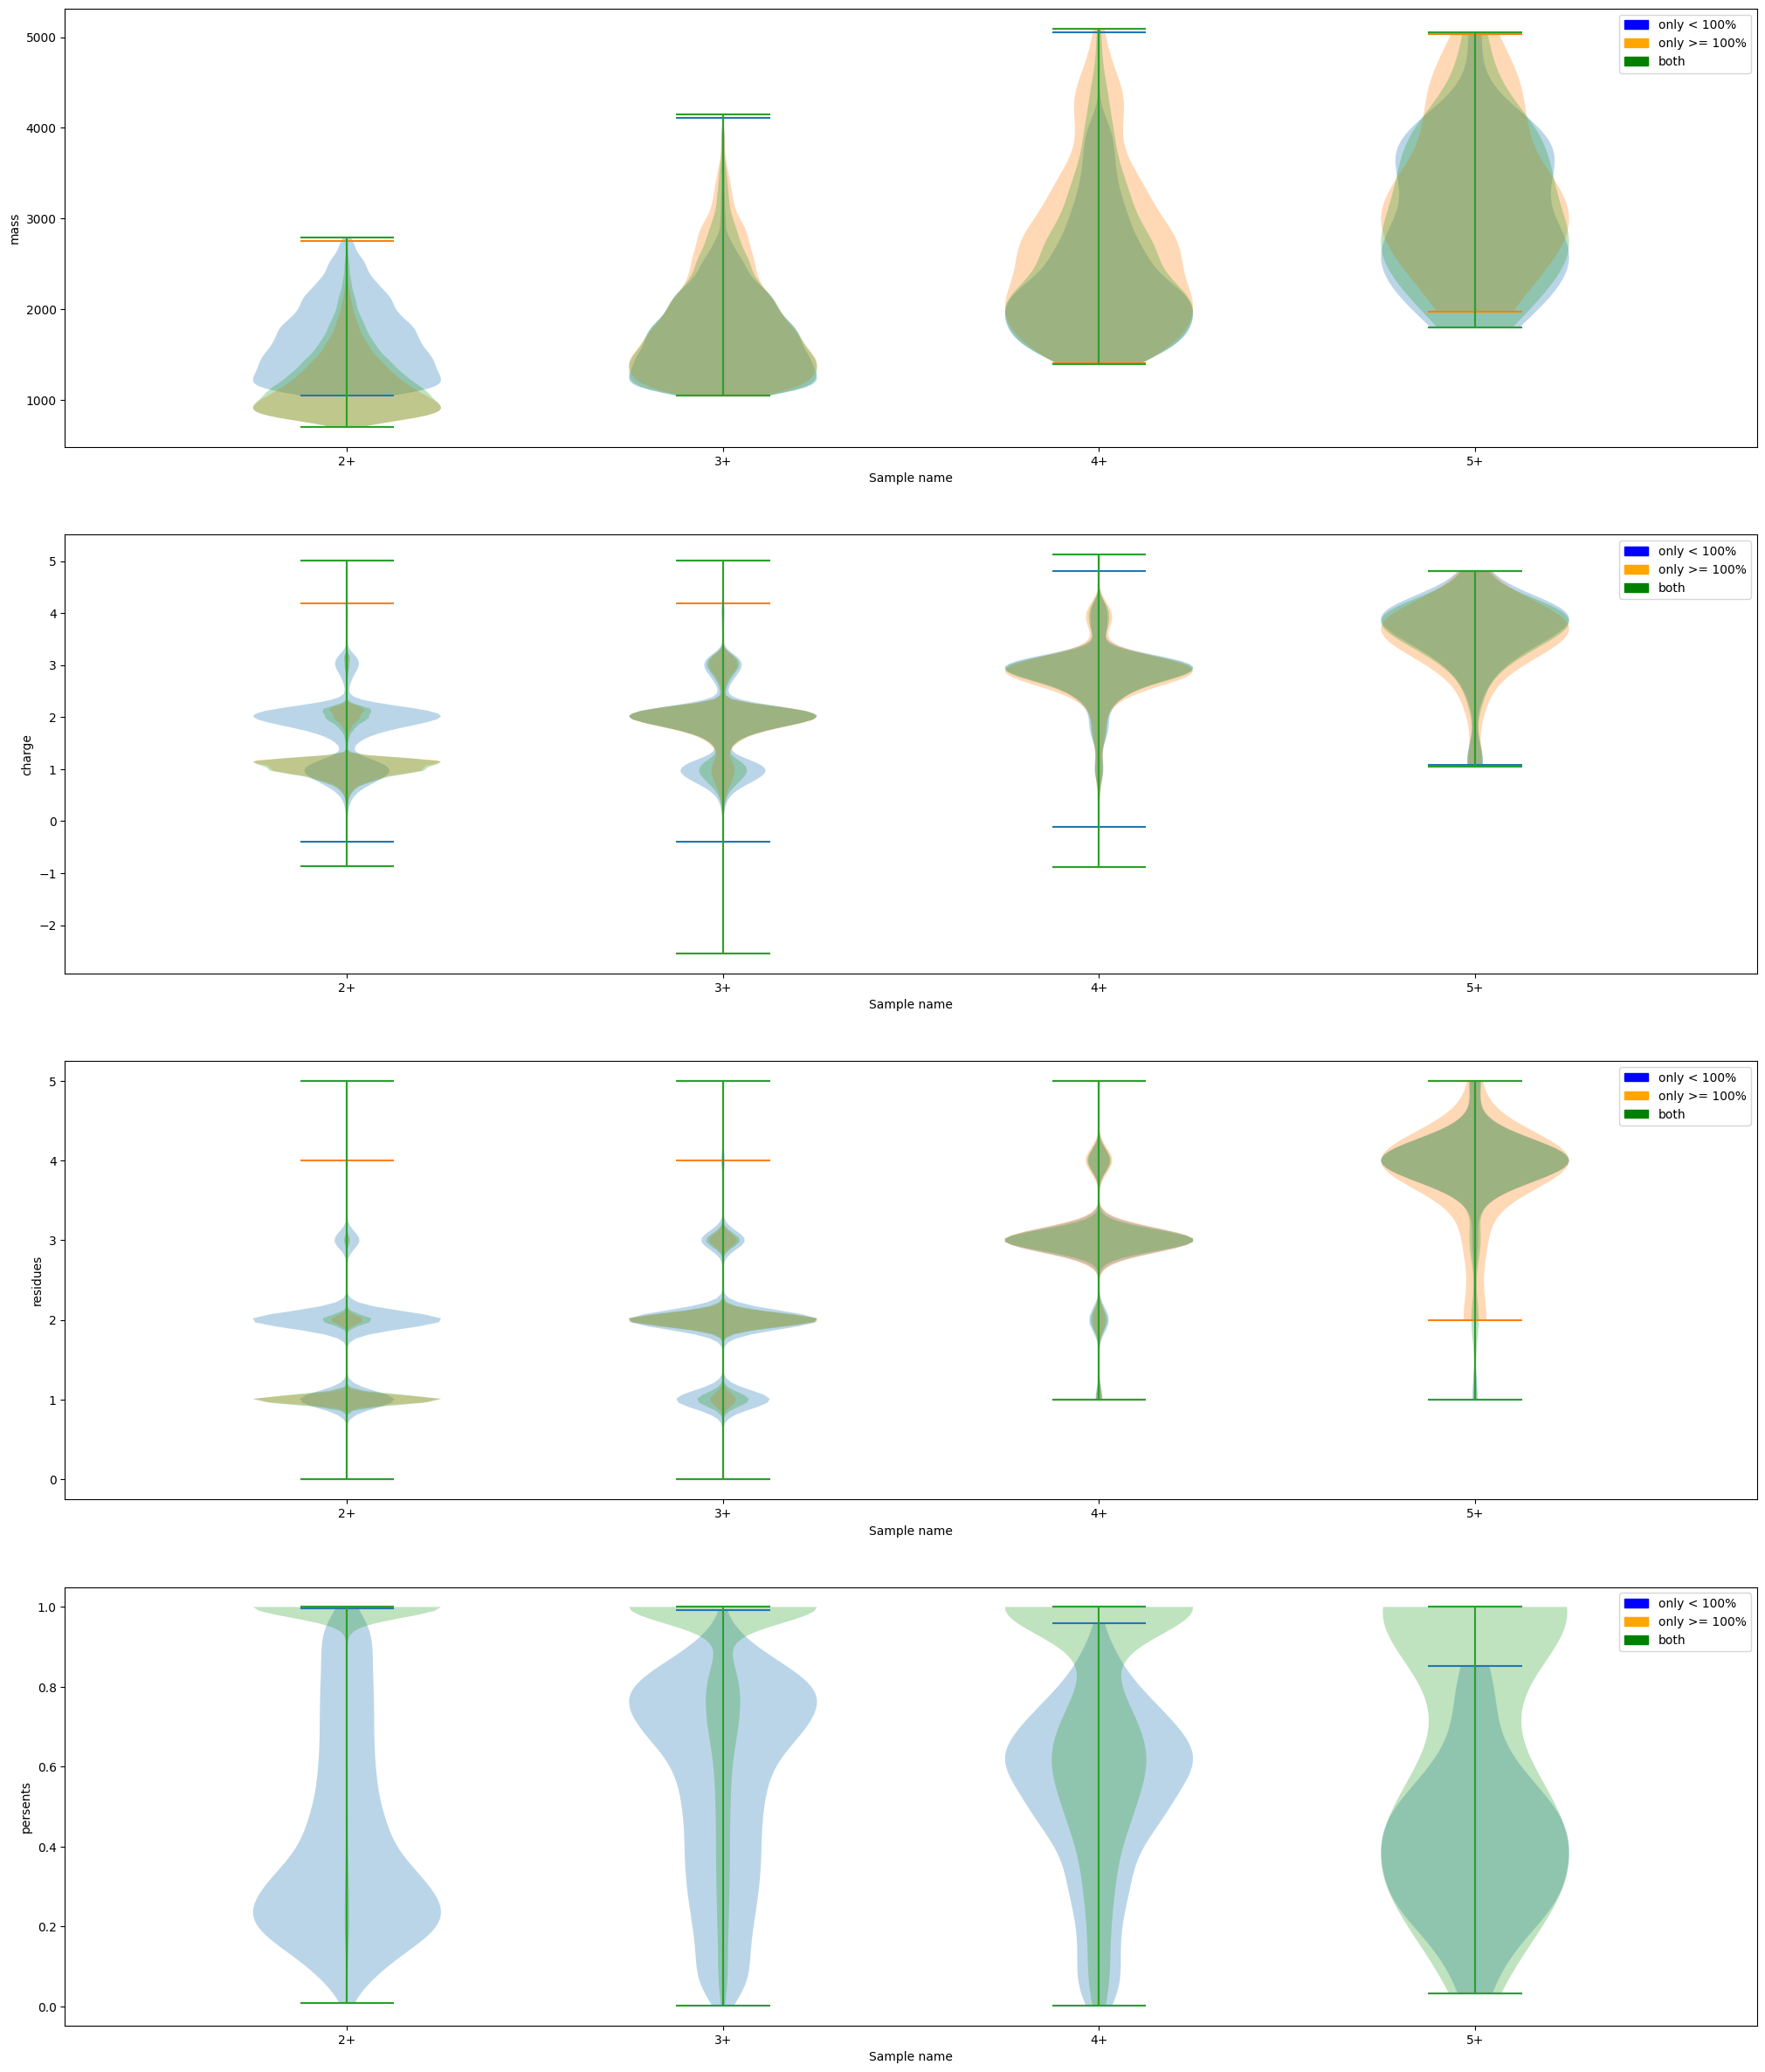

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(25,30))
plot_labels = ['only < 100%', 'only >= 100%', 'both']
ax[0].violinplot(mass)
ax[0].violinplot(mass_2)
ax[0].violinplot(mass_3)
ax[0].set_xlabel("Charge")
ax[0].set_ylabel("mass")
red_patch = mpatches.Patch(color='blue')
orange_patch = mpatches.Patch(color='orange')
green_patch = mpatches.Patch(color='green')
ax[0].legend([red_patch, orange_patch, green_patch], plot_labels)
set_axis_style(ax[0], ['2+', '3+', '4+', '5+'])

ax[1].violinplot(charge)
ax[1].violinplot(charge_2)
ax[1].violinplot(charge_3)
ax[1].set_xlabel("Charge")
ax[1].set_ylabel("charge")
ax[1].legend([red_patch, orange_patch, green_patch], plot_labels)
set_axis_style(ax[1], ['2+', '3+', '4+', '5+'])

ax[2].violinplot(residues)
ax[2].violinplot(residues_2)
ax[2].violinplot(residues_3)
ax[2].set_xlabel("Charge")
ax[2].set_ylabel("residues")
ax[2].legend([red_patch, orange_patch, green_patch], plot_labels)
set_axis_style(ax[2], ['2+', '3+', '4+', '5+'])

ax[3].violinplot(persents)
ax[3].violinplot(persents_2)
ax[3].violinplot(persents_3)
ax[3].set_xlabel("Charge")
ax[3].set_ylabel("persents")
ax[3].legend([red_patch, orange_patch, green_patch], plot_labels)
set_axis_style(ax[3], ['2+', '3+', '4+', '5+'])

plt.show()

In [15]:
find_peptide(dic,"electrochem.charge(dic[i][k]['sequence'], pH=PH) < 0")

{2: {'sequence': 'ITIADCGQLE', 'abundance': 729221952, 'ion_moz': 560.2713012695312, 'master_quant_peptide_ion_id': 359736, '%': 1.0, 'Masse': -31.689800807643422, 'Mass_excel': 1118.5280505390624}, 'total': 729221952}
-0.05666339935305309


In [9]:
count = 0
for i in dic.keys():
    for j in dic[i].keys():
        if j != 'total':
            if j == 5:
                count += 1
print(count)

60
